In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from PIL import Image
from collections import Counter
import torch
from torch.autograd import Variable
import torch.nn as nn
import cv2
import os
import sys
from torchvision import transforms
from torch.optim import Adam
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
import pycountry
from more_itertools import locate

In [2]:
sys.modules['torch']

<module 'torch' from 'C:\\ProgramData\\Anaconda\\lib\\site-packages\\torch\\__init__.py'>

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Deep Learning HW2

In [4]:
data = pd.read_csv('covid_19.csv', header=None)
data = data.drop([1,2], axis=1).drop([1,2])
dataT = data.T.iloc[1:,1:]
dataT.columns = data.iloc[1::,0]
dataT = pd.concat([data.T.iloc[1:,0], dataT.astype(int)], axis=1)
dataT.head()

,0,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
3,1/22/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1/23/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
5,1/24/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
6,1/25/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
7,1/26/20,0,0,0,0,0,0,0,0,4,...,0,0,0,0,2,0,0,0,0,0


In [5]:
crease = pd.DataFrame(np.array(data.iloc[1:,2:].astype(int))-np.array(data.iloc[1:,1:-1].astype(int))).T
crease.columns = data.iloc[1:,0]
crease.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
76,21,17,104,19,2,0,87,28,115,303,...,5525,0,25,2,2,2,0,0,0,0
77,40,9,94,19,0,0,80,40,98,302,...,4398,32,37,4,4,0,0,0,0,0
78,37,7,95,18,0,0,180,16,107,311,...,8733,17,42,0,2,4,0,1,1,2
79,34,17,64,0,0,2,0,30,88,251,...,5269,21,143,4,1,1,0,0,0,1
80,52,13,89,37,0,0,167,46,12,139,...,5332,-14,98,6,4,22,2,0,3,0


## 1.1

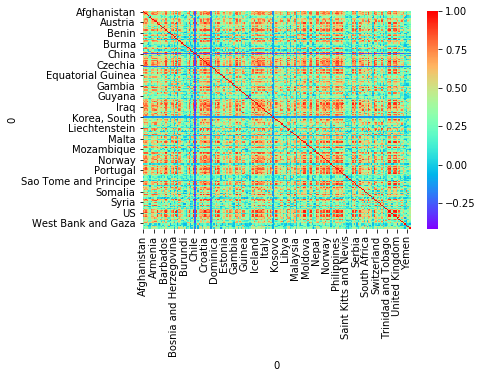

In [6]:
corheatmap = crease.corr()
corheatmap
sns.heatmap(corheatmap, cmap='rainbow')

## 1.2

In [7]:
country = []
for i in np.arange(1, len(corheatmap)):
    for j in range(i):
        if corheatmap.iloc[i][j]>0.7:
            country.append(corheatmap.columns[i])
            country.append(corheatmap.columns[j])
c = list(Counter(country))
subseq = dataT[c] #start from 1/22

In [8]:
label = copy.copy(crease)
label[crease>0] = 1
label[crease<=0] = 0
label['date'] = np.array(data.iloc[0,2:]) #start from 1/23

In [9]:
L = 40
start_index = 38 #start from 3/1
for i in range(crease.shape[0]-start_index-L+1):
    if i==0:
        total_subseq = subseq.iloc[start_index+i:start_index+L+i,:].T.values
        total_labels = label[c].iloc[start_index+L,:].values
        
    else:
        total_subseq = np.vstack((total_subseq, subseq.iloc[start_index+i:start_index+L+i,:].T.values))
        total_labels = np.append(total_labels, label[c].iloc[start_index+L,:].values)
end = crease.shape[0]-start_index-L+1
pred_subseq = torch.FloatTensor(dataT.drop(0, axis=1).iloc[start_index+end:start_index+L+end,:].T.values)[:,:,np.newaxis]

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(total_subseq, total_labels, test_size=0.3, random_state=42)
train_data = torch.FloatTensor(train_data[:,:,np.newaxis])
test_data = torch.FloatTensor(test_data[:,:,np.newaxis])
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)
test_labels.shape

torch.Size([172])

# 1.3

In [11]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(      #一層RNN
            input_size=1,
            hidden_size=32,     # RNN hidden unit
            num_layers=1,       # RNN layers
            batch_first=True,   #(batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 2)

    def forward(self, x):  
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        h_state = None # 要使用初始 hidden state, 可以设成 None
        
        r_out, h_state = self.rnn(x, h_state)   # h_state 也要作为 RNN 的一个输入
        output = self.out(r_out[:,-1,:])
        
        return output


rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)


In [16]:
def run_rnn(n_epoch, batch_size, train_data, train_labels, test_data, test_labels, model):
    cross_entropy = []
    train_acc_rate = []
    test_acc_rate = []
    
    for epoch in range(n_epoch):
        train_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0

        model.train()
        index = torch.randperm(train_data.shape[0])
        train_data = train_data[index]
        train_labels = train_labels[index]

        for batch in range(int(train_data.shape[0]/batch_size)):
            data = train_data[batch*batch_size:(batch+1)*batch_size]
            labels = train_labels[batch*batch_size:(batch+1)*batch_size]
            
            train_output = model(data)   

            loss = loss_func(train_output, labels)     # cross entropy loss
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            
            train_loss += loss.item()*data.shape[0]
            _, train_pred = torch.max(train_output.data, 1)
            train_acc += torch.sum(train_pred == labels.data)
        cross_entropy.append(train_loss/train_data.shape[0])
        train_acc_rate.append(train_acc/train_data.shape[0])
        
        ##test
        model.eval()
        test_output = model(test_data)
        # convert output probabilities to predicted class
        _, test_pred = torch.max(test_output.data, 1)
        # compare predictions to true label
        test_acc += torch.sum(test_pred == test_labels.data)
        test_acc_rate.append(test_acc/test_data.shape[0])
        print('Epoch = %d, train_loss = %f, train_acc = %f, test_acc= %f' % \
              (epoch, train_loss/train_data.shape[0], train_acc/train_data.shape[0], test_acc/test_data.shape[0]))
        
    
    return cross_entropy, train_acc_rate, test_acc_rate

In [11]:
np.random.seed(5)
n_epoch = 500
batch_size = 64
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)   # optimize all rnn parameters
loss_func = nn.CrossEntropyLoss()

NameError: name 'rnn' is not defined

In [82]:
cross_entropy, train_acc_rate, test_acc_rate = run_rnn(n_epoch, batch_size, train_data, train_labels, test_data, test_labels, rnn)

Epoch = 0, train_loss = 0.841980, train_acc = 0.117500, test_acc= 0.075581
Epoch = 1, train_loss = 0.669435, train_acc = 0.440000, test_acc= 0.924419
Epoch = 2, train_loss = 0.510790, train_acc = 0.845000, test_acc= 0.924419
Epoch = 3, train_loss = 0.416247, train_acc = 0.842500, test_acc= 0.924419
Epoch = 4, train_loss = 0.372832, train_acc = 0.845000, test_acc= 0.924419
Epoch = 5, train_loss = 0.350255, train_acc = 0.847500, test_acc= 0.924419
Epoch = 6, train_loss = 0.344690, train_acc = 0.845000, test_acc= 0.924419
Epoch = 7, train_loss = 0.332602, train_acc = 0.847500, test_acc= 0.924419
Epoch = 8, train_loss = 0.331869, train_acc = 0.845000, test_acc= 0.924419
Epoch = 9, train_loss = 0.327992, train_acc = 0.847500, test_acc= 0.924419
Epoch = 10, train_loss = 0.317470, train_acc = 0.852500, test_acc= 0.930233
Epoch = 11, train_loss = 0.315595, train_acc = 0.855000, test_acc= 0.930233
Epoch = 12, train_loss = 0.316336, train_acc = 0.855000, test_acc= 0.936047
Epoch = 13, train_loss

Epoch = 213, train_loss = 0.222265, train_acc = 0.867500, test_acc= 0.918605
Epoch = 214, train_loss = 0.222358, train_acc = 0.867500, test_acc= 0.918605
Epoch = 215, train_loss = 0.226748, train_acc = 0.865000, test_acc= 0.918605
Epoch = 216, train_loss = 0.216328, train_acc = 0.872500, test_acc= 0.924419
Epoch = 217, train_loss = 0.221600, train_acc = 0.867500, test_acc= 0.918605
Epoch = 218, train_loss = 0.222172, train_acc = 0.865000, test_acc= 0.918605
Epoch = 219, train_loss = 0.217778, train_acc = 0.870000, test_acc= 0.918605
Epoch = 220, train_loss = 0.227027, train_acc = 0.865000, test_acc= 0.918605
Epoch = 221, train_loss = 0.223314, train_acc = 0.867500, test_acc= 0.918605
Epoch = 222, train_loss = 0.219541, train_acc = 0.870000, test_acc= 0.918605
Epoch = 223, train_loss = 0.215574, train_acc = 0.872500, test_acc= 0.918605
Epoch = 224, train_loss = 0.211580, train_acc = 0.872500, test_acc= 0.918605
Epoch = 225, train_loss = 0.224665, train_acc = 0.865000, test_acc= 0.918605

Epoch = 425, train_loss = 0.191053, train_acc = 0.877500, test_acc= 0.924419
Epoch = 426, train_loss = 0.195752, train_acc = 0.872500, test_acc= 0.936047
Epoch = 427, train_loss = 0.199014, train_acc = 0.872500, test_acc= 0.936047
Epoch = 428, train_loss = 0.187032, train_acc = 0.885000, test_acc= 0.936047
Epoch = 429, train_loss = 0.191378, train_acc = 0.880000, test_acc= 0.936047
Epoch = 430, train_loss = 0.191922, train_acc = 0.880000, test_acc= 0.941860
Epoch = 431, train_loss = 0.185308, train_acc = 0.885000, test_acc= 0.941860
Epoch = 432, train_loss = 0.187400, train_acc = 0.882500, test_acc= 0.936047
Epoch = 433, train_loss = 0.189557, train_acc = 0.877500, test_acc= 0.930233
Epoch = 434, train_loss = 0.182365, train_acc = 0.885000, test_acc= 0.936047
Epoch = 435, train_loss = 0.181678, train_acc = 0.885000, test_acc= 0.941860
Epoch = 436, train_loss = 0.190320, train_acc = 0.875000, test_acc= 0.941860
Epoch = 437, train_loss = 0.186405, train_acc = 0.880000, test_acc= 0.941860

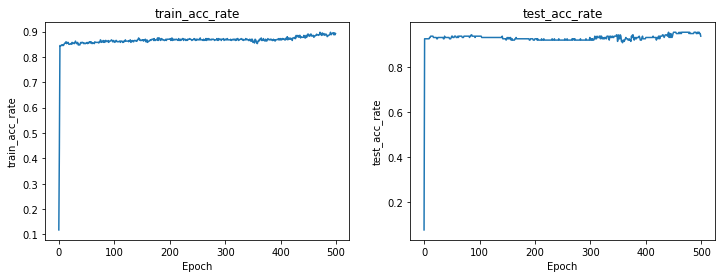

In [83]:
fig=plt.figure(figsize=(12,4))
##
plt.subplot(121) 
plt.plot(range(n_epoch), train_acc_rate)
plt.xlabel("Epoch")
plt.ylabel("train_acc_rate")
plt.title('train_acc_rate')
##
plt.subplot(122) 
plt.plot(range(n_epoch), test_acc_rate)
plt.xlabel("Epoch")
plt.ylabel("test_acc_rate")
plt.title('test_acc_rate')

plt.show()

# 1.4

In [17]:
class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()

        self.lstm = nn.LSTM(     
            input_size=1,      
            hidden_size=64,     # rnn hidden unit
            num_layers=1,       # 有几层 RNN layers
            batch_first=True,   # 改以batch在前面 e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 2)    # 输出层

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)   LSTM 有两个 hidden states, h_n 是分线, h_c 是主线
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全0的 state
        out = self.out(r_out[:, -1, :])
        return out

lstm = lstm()
print(lstm)

lstm(
  (lstm): LSTM(1, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)


In [18]:
np.random.seed(5)
n_epoch = 500
batch_size = 64
learning_rate = 0.001
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)   # optimize all rnn parameters
loss_func = nn.CrossEntropyLoss()

In [19]:
cross_entropy, train_acc_rate, test_acc_rate = run_rnn(n_epoch, batch_size, train_data, train_labels, test_data, test_labels, lstm)

Epoch = 0, train_loss = 0.766393, train_acc = 0.137500, test_acc= 0.127907
Epoch = 1, train_loss = 0.635919, train_acc = 0.615000, test_acc= 0.924419
Epoch = 2, train_loss = 0.486319, train_acc = 0.845000, test_acc= 0.924419
Epoch = 3, train_loss = 0.390575, train_acc = 0.850000, test_acc= 0.924419
Epoch = 4, train_loss = 0.359065, train_acc = 0.842500, test_acc= 0.924419
Epoch = 5, train_loss = 0.328694, train_acc = 0.850000, test_acc= 0.924419
Epoch = 6, train_loss = 0.333259, train_acc = 0.842500, test_acc= 0.924419
Epoch = 7, train_loss = 0.316877, train_acc = 0.847500, test_acc= 0.924419
Epoch = 8, train_loss = 0.322270, train_acc = 0.845000, test_acc= 0.924419
Epoch = 9, train_loss = 0.317187, train_acc = 0.847500, test_acc= 0.924419
Epoch = 10, train_loss = 0.322124, train_acc = 0.842500, test_acc= 0.924419
Epoch = 11, train_loss = 0.314141, train_acc = 0.845000, test_acc= 0.924419
Epoch = 12, train_loss = 0.306660, train_acc = 0.847500, test_acc= 0.924419
Epoch = 13, train_loss

Epoch = 213, train_loss = 0.001430, train_acc = 0.960000, test_acc= 0.976744
Epoch = 214, train_loss = 0.001467, train_acc = 0.960000, test_acc= 0.976744
Epoch = 215, train_loss = 0.001392, train_acc = 0.960000, test_acc= 0.976744
Epoch = 216, train_loss = 0.001333, train_acc = 0.960000, test_acc= 0.976744
Epoch = 217, train_loss = 0.001320, train_acc = 0.960000, test_acc= 0.976744
Epoch = 218, train_loss = 0.001188, train_acc = 0.960000, test_acc= 0.976744
Epoch = 219, train_loss = 0.001254, train_acc = 0.960000, test_acc= 0.976744
Epoch = 220, train_loss = 0.001239, train_acc = 0.960000, test_acc= 0.982558
Epoch = 221, train_loss = 0.001170, train_acc = 0.960000, test_acc= 0.976744
Epoch = 222, train_loss = 0.001208, train_acc = 0.960000, test_acc= 0.982558
Epoch = 223, train_loss = 0.001246, train_acc = 0.960000, test_acc= 0.976744
Epoch = 224, train_loss = 0.001227, train_acc = 0.960000, test_acc= 0.976744
Epoch = 225, train_loss = 0.001323, train_acc = 0.960000, test_acc= 0.976744

Epoch = 425, train_loss = 0.000228, train_acc = 0.960000, test_acc= 0.976744
Epoch = 426, train_loss = 0.000229, train_acc = 0.960000, test_acc= 0.976744
Epoch = 427, train_loss = 0.000232, train_acc = 0.960000, test_acc= 0.976744
Epoch = 428, train_loss = 0.000229, train_acc = 0.960000, test_acc= 0.976744
Epoch = 429, train_loss = 0.000222, train_acc = 0.960000, test_acc= 0.976744
Epoch = 430, train_loss = 0.000212, train_acc = 0.960000, test_acc= 0.976744
Epoch = 431, train_loss = 0.000220, train_acc = 0.960000, test_acc= 0.976744
Epoch = 432, train_loss = 0.000214, train_acc = 0.960000, test_acc= 0.976744
Epoch = 433, train_loss = 0.000219, train_acc = 0.960000, test_acc= 0.976744
Epoch = 434, train_loss = 0.000213, train_acc = 0.960000, test_acc= 0.976744
Epoch = 435, train_loss = 0.000216, train_acc = 0.960000, test_acc= 0.976744
Epoch = 436, train_loss = 0.000216, train_acc = 0.960000, test_acc= 0.976744
Epoch = 437, train_loss = 0.000205, train_acc = 0.960000, test_acc= 0.976744

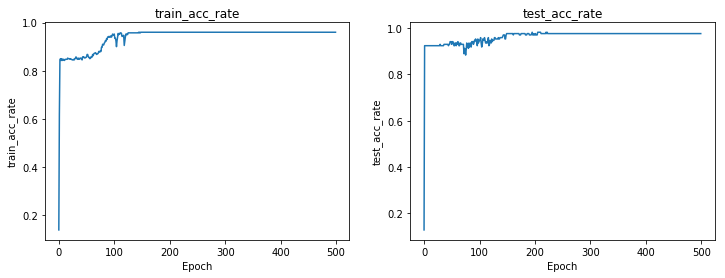

In [20]:
fig=plt.figure(figsize=(12,4))
##
plt.subplot(121) 
plt.plot(range(n_epoch), train_acc_rate)
plt.xlabel("Epoch")
plt.ylabel("train_acc_rate")
plt.title('train_acc_rate')
##
plt.subplot(122) 
plt.plot(range(n_epoch), test_acc_rate)
plt.xlabel("Epoch")
plt.ylabel("test_acc_rate")
plt.title('test_acc_rate')

plt.show()

# 1.5

In [53]:
import torch.nn.functional as F
pred_output = lstm(pred_subseq) 
_, pred = torch.max(pred_output.data, 1)

In [58]:
# 將國家轉換為2個音文字母的代碼
country_set = crease.columns
input_countries = country_set.tolist()
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2
codes = [countries.get(country, 'Unknown code') for country in input_countries] 
#找到對應的'Unknown code'正確代碼
indices = list(locate(codes, lambda x: x == 'Unknown code'))
subcode = []
unknown = []
for i in range(len(indices)):
    try:
        subcode.append(pycountry.countries.lookup(country_set[indices][i]).alpha_2)
    except:
        unknown.append(country_set[indices][i])
subcode = ['BO', 'BN', 'BU', 'CG', 'CD', 'CI', 'Diamond Princess', 'VA', 'IR', 'KR', 'kosovo', 'LA', 'MS Zaandam', 'MD', 'RU', 'SY', 'TW', 'TZ', 'us', 'VE', 'VN', 'West Bank and Gaza']
for i in range(len(indices)):
    codes[indices[i]] = subcode[i]
country_code = np.array([x.lower() for x in codes])

In [55]:
pred_1 = country_code[list(locate(pred_label, lambda x: x == 1))].tolist()
pred_0 = country_code[list(locate(pred_label, lambda x: x == 0))].tolist()

OSError: no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0x7e

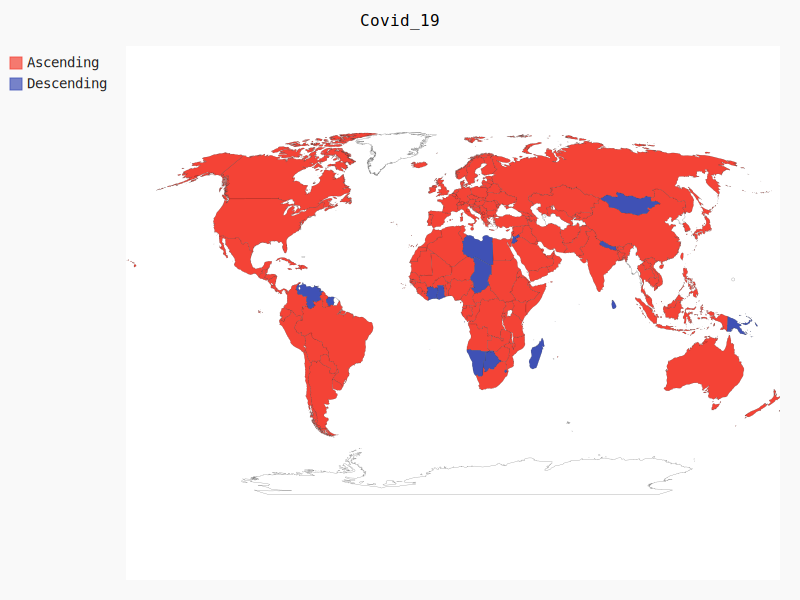

In [56]:
import pygal_maps_world.maps
worldmap_chart = pygal_maps_world.maps.World()
worldmap_chart.title = 'Covid_19'
worldmap_chart.add('Ascending', pred_1)
worldmap_chart.add('Descending', pred_0)

# VAE

# 2.1

In [40]:
np.random.seed(5)
##read picture
data_images = []
for i in range(21551):
    filepath = 'data/'
    filename = str((i+1)) +'.png'
    image = np.array(Image.open(filepath+filename).convert('RGB'))/255
    image = cv2.resize(image, (28, 28), interpolation=cv2.INTER_CUBIC)
    image = np.moveaxis(image, 2, 0)
    data_images.append(image)
data_images = torch.from_numpy(np.array(data_images))
data_images

tensor([[[[ 0.9641,  0.8420,  0.7696,  ...,  0.7644,  0.6820,  0.7079],
          [ 0.9792,  0.7130,  0.7251,  ...,  0.7284,  0.6382,  0.6796],
          [ 0.8217,  0.6785,  0.8719,  ...,  0.7190,  0.6663,  0.6855],
          ...,
          [ 0.9999,  0.9953,  0.9540,  ...,  0.9533,  0.9981,  0.9981],
          [ 1.0000,  0.9983,  0.9934,  ...,  0.2741,  0.9931,  0.9958],
          [ 1.0005,  0.9791,  0.9801,  ...,  0.3806,  0.4335,  0.9855]],

         [[ 0.7135,  0.5247,  0.3652,  ...,  0.3923,  0.3227,  0.3310],
          [ 0.7277,  0.3232,  0.4355,  ...,  0.3367,  0.3197,  0.3065],
          [ 0.5009,  0.3050,  0.6021,  ...,  0.3490,  0.3062,  0.3137],
          ...,
          [ 0.9999,  0.9953,  0.9542,  ...,  0.9452,  0.9981,  0.9981],
          [ 1.0000,  0.9999,  0.9980,  ...,  0.1726,  0.9874,  0.9970],
          [ 1.0011,  0.9934,  0.9944,  ...,  0.3251,  0.3892,  0.9902]],

         [[ 0.6448,  0.5278,  0.4789,  ...,  0.4828,  0.4115,  0.4250],
          [ 0.6456,  0.4312,  

# 2.2~2.4

In [58]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=3*28*28, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # 保准方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    # 编码过程
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码过程
    def decode(self, z):
        h = torch.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    # 整个前向传播过程：编码-》解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [59]:
image_size = 3*28*28
h_dim = 400
z_dim = 50
model = VAE(image_size=image_size, h_dim=h_dim, z_dim=z_dim).to(device)
num_epochs = 200
batch_size = 64
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss(reduction='sum')
train_data = data_images.float()

In [60]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [61]:
elbo = []
for epoch in range(num_epochs):
    index = torch.randperm(train_data.shape[0])
    train_data = train_data[index]
    for batch in range(int(train_data.shape[0]/batch_size)+1):
        if batch == range(int(train_data.shape[0]/batch_size)+1)[-1]:
            x = train_data[batch*batch_size:]
        else:
            x = train_data[batch*batch_size:(batch+1)*batch_size]

        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
         
        reconst_loss = loss_fn(x_reconst, x)
        kl_div = -0.5*torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        loss = reconst_loss + 0*kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch+1) % 100 == 0:
            print ("Epoch = %d, loss = %f " %(epoch+1, loss)
    elbo.append(loss.item())
        
    if (epoch+1) % 20 == 0 :
        with torch.no_grad():
            # 隨機生成
            z = torch.randn(batch_size, z_dim)
            out = model.decode(z).view(-1, 3, 28, 28)
            save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

            # 重構
            out, _, _ = model(x)
            x_concat = torch.cat([x.view(-1, 3, 28, 28), out.view(-1, 3, 28, 28)], dim=3)
            save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))


Epoch[1/200], Step [100/337], Reconst Loss: 1327.0375, KL Div: 18720.8984
Epoch[1/200], Step [200/337], Reconst Loss: 1299.2020, KL Div: 19429.2012
Epoch[1/200], Step [300/337], Reconst Loss: 1279.6478, KL Div: 20429.7441
Epoch[2/200], Step [100/337], Reconst Loss: 1269.6588, KL Div: 23134.0469
Epoch[2/200], Step [200/337], Reconst Loss: 1247.7706, KL Div: 22990.8438
Epoch[2/200], Step [300/337], Reconst Loss: 1242.9835, KL Div: 24003.1504
Epoch[3/200], Step [100/337], Reconst Loss: 1234.2618, KL Div: 24058.1230
Epoch[3/200], Step [200/337], Reconst Loss: 1246.8414, KL Div: 26024.8750
Epoch[3/200], Step [300/337], Reconst Loss: 1232.7144, KL Div: 26037.1250
Epoch[4/200], Step [100/337], Reconst Loss: 1230.3927, KL Div: 26149.0312
Epoch[4/200], Step [200/337], Reconst Loss: 1202.4343, KL Div: 27477.2676
Epoch[4/200], Step [300/337], Reconst Loss: 1244.0072, KL Div: 29380.4551
Epoch[5/200], Step [100/337], Reconst Loss: 1205.2928, KL Div: 29970.7441
Epoch[5/200], Step [200/337], Reconst 

Epoch[73/200], Step [300/337], Reconst Loss: 1184.1080, KL Div: 82181.6562
Epoch[74/200], Step [100/337], Reconst Loss: 1193.1342, KL Div: 82204.7031
Epoch[74/200], Step [200/337], Reconst Loss: 1180.2433, KL Div: 81116.5000
Epoch[74/200], Step [300/337], Reconst Loss: 1176.3148, KL Div: 83434.1484
Epoch[75/200], Step [100/337], Reconst Loss: 1197.1864, KL Div: 80508.1016
Epoch[75/200], Step [200/337], Reconst Loss: 1185.6719, KL Div: 81430.6797
Epoch[75/200], Step [300/337], Reconst Loss: 1199.7705, KL Div: 81803.9688
Epoch[76/200], Step [100/337], Reconst Loss: 1178.1934, KL Div: 81991.3594
Epoch[76/200], Step [200/337], Reconst Loss: 1195.8735, KL Div: 82725.9531
Epoch[76/200], Step [300/337], Reconst Loss: 1215.8212, KL Div: 81094.7578
Epoch[77/200], Step [100/337], Reconst Loss: 1200.3752, KL Div: 82764.1406
Epoch[77/200], Step [200/337], Reconst Loss: 1189.3185, KL Div: 81865.7656
Epoch[77/200], Step [300/337], Reconst Loss: 1211.6289, KL Div: 84499.9297
Epoch[78/200], Step [100/

Epoch[145/200], Step [200/337], Reconst Loss: 1178.6040, KL Div: 97609.7500
Epoch[145/200], Step [300/337], Reconst Loss: 1198.0699, KL Div: 96768.1406
Epoch[146/200], Step [100/337], Reconst Loss: 1190.2233, KL Div: 95794.5781
Epoch[146/200], Step [200/337], Reconst Loss: 1192.5706, KL Div: 98785.5078
Epoch[146/200], Step [300/337], Reconst Loss: 1198.8765, KL Div: 98796.1641
Epoch[147/200], Step [100/337], Reconst Loss: 1160.4283, KL Div: 101374.3125
Epoch[147/200], Step [200/337], Reconst Loss: 1184.2611, KL Div: 99153.1094
Epoch[147/200], Step [300/337], Reconst Loss: 1176.0723, KL Div: 98914.7500
Epoch[148/200], Step [100/337], Reconst Loss: 1190.9916, KL Div: 101109.2656
Epoch[148/200], Step [200/337], Reconst Loss: 1197.0032, KL Div: 98794.8047
Epoch[148/200], Step [300/337], Reconst Loss: 1204.7853, KL Div: 99034.2188
Epoch[149/200], Step [100/337], Reconst Loss: 1200.3337, KL Div: 101196.1406
Epoch[149/200], Step [200/337], Reconst Loss: 1184.9856, KL Div: 99227.9297
Epoch[149

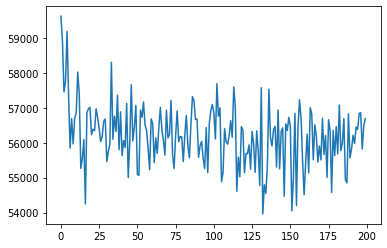

In [62]:
plt.plot(elbo)

# 2.5

In [63]:
two_pic = data_images[0:2].float()
two_pic = two_pic.to(device).view(-1, image_size)
out, _, _ = model(two_pic)
out = out.view(-1, 3, 28, 28)
pic = two_pic.view(-1, 3, 28, 28)[0]
for i in np.arange(0.1, 1, 0.1):
    pic = torch.cat([pic, (1-i)*out[0]+i*out[1]], dim=2)
pic = torch.cat([pic, two_pic.view(-1, 3, 28, 28)[1]], dim=2)
save_image(pic, os.path.join(sample_dir, 'two picture.png'))